## Setup

In [5]:
%matplotlib inline
import glob
import sys
import shutil
from pathlib import Path

import os
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix

In [2]:
mkdir ~/data/asc_desc_combined

In [3]:
cd ~/data/asc_desc_combined

/home/fw/data/asc_desc_combined


## Set name

In [9]:
name = 'velocity_2_25_2020'
asc = Path('/home/fw/data/asc_upper')
desc = Path('/home/fw/data/desc_lower')

asc = asc / (name + '_mask.h5')
desc = desc / (name + '_mask.h5')

out_path = Path('/mnt/i/hyp3_downloads/full_results')

## To hz up

In [10]:
# !asc_desc2horz_vert.py -h

hz_out = Path.cwd() / (name+'_hz.h5')
up_out = Path.cwd() / (name+'_up.h5')

hz_std_out = Path.cwd() / (name+'_hz_std.h5')
up_std_out = Path.cwd() / (name+'_up_std.h5')

!asc_desc2horz_vert.py {asc} {desc} --max-ref-yx-diff 1000 -o {hz_out} {up_out}
!asc_desc2horz_vert.py {asc} {desc} -d velocityStd --max-ref-yx-diff 1000 -o {hz_std_out} {up_std_out}

!save_gdal.py {up_out} -o {out_path / (up_out.name.split('.')[0] + '.tif')}
!save_gdal.py {hz_out} -o {out_path / (hz_out.name.split('.')[0] + '.tif')}

---------------------
common area in SNWE: (5551640.0, 5652960.0, 271360.0, 460920.0)
read from file: /home/fw/data/asc_upper/velocity_2_25_2020_mask.h5
read from file: /home/fw/data/desc_lower/velocity_2_25_2020_mask.h5
---------------------
get design matrix
LOS incidence angle: 35.7542225214827 deg
LOS azimuth angle: 103.64306290000002 deg
LOS incidence angle: 35.729492659960165 deg
LOS azimuth angle: -103.77717740000003 deg
project asc/desc into horz/vert direction
---------------------
writing horizontal component to file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_hz.h5
delete exsited file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_hz.h5
create HDF5 file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_hz.h5 with w mode
create dataset /velocity of float32    in size of (2533, 4739)         with compression=None
finished writing to /home/fw/data/asc_desc_combined/velocity_2_25_2020_hz.h5
writing   vertical component to file: /home/fw/data/asc_desc_combined/velo

view.py velocity_2_25_2020_up.h5 --noverbose


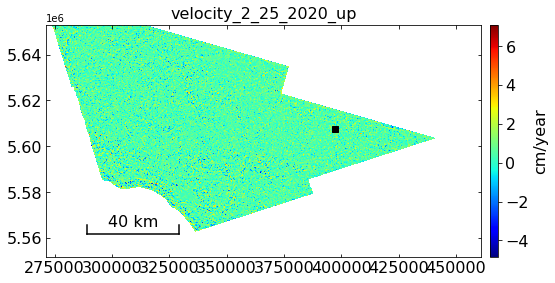

In [22]:
view.main('velocity_2_25_2020_up.h5 --noverbose'.split())

create HDF5 file: valid_area.h5 with w mode
create dataset /valid of float64    in size of (2533, 4739)         with compression=None
finished writing to valid_area.h5


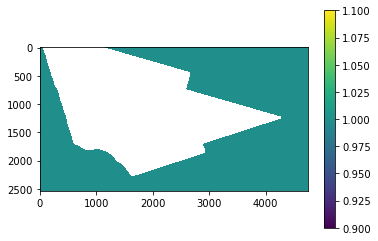

In [34]:
data, atr = readfile.read('velocity_2_25_2020_up.h5')
null = np.isnan(data).astype(float)
null[null==0] = np.nan
writefile.write({'valid':null},'valid_area.h5',ref_file='velocity_2_25_2020_up.h5')
plt.imshow(null)
plt.colorbar()

In [35]:
!save_gdal.py valid_area.h5 -o {out_path / 'valid_area.tif'}

read metadata from file: valid_area.h5
read data     from file: valid_area.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2533, 4739
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /mnt/i/hyp3_downloads/full_results/valid_area.tif


## Masking

In [11]:
from skimage.morphology import remove_small_objects
import numpy as np

In [15]:
def vel_filter(vel_file, std_file, out_file, min_size=10):
    # load data
    data, _ = readfile.read(vel_file)
    data_std, _ = readfile.read(std_file)
    
    # temporal standard deviation filter
    data_mean = np.nanmean(data)
    mask_std = np.abs(data-data_mean) > (data_std * 2)
    data[~mask_std] = np.nan
    
    # spatial standard deviation filter
    m, s = np.nanmean(data), np.nanstd(data)
    mask_val = (data > m+s*2) | (data < m-s*2)
    
    # remove small objects
    remove_small_objects(mask_val,min_size=min_size,in_place=True)
    data[~mask_val] = np.nan

    # write file
    writefile.write({'velocity':data}, out_file=out_file, ref_file=vel_file)
    
    return data

In [17]:
up_mask = Path.cwd() / (up_out.name.split('.')[0] + '_mask.h5')
hz_mask = Path.cwd() / (hz_out.name.split('.')[0] + '_mask.h5')

up_data = vel_filter(up_out,up_std_out,up_mask)
hz_data = vel_filter(hz_out,hz_std_out,hz_mask)

delete exsited file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_up_mask.h5
create HDF5 file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_up_mask.h5 with w mode
create dataset /velocity of float32    in size of (2533, 4739)         with compression=None
finished writing to /home/fw/data/asc_desc_combined/velocity_2_25_2020_up_mask.h5
delete exsited file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_hz_mask.h5
create HDF5 file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_hz_mask.h5 with w mode
create dataset /velocity of float32    in size of (2533, 4739)         with compression=None
finished writing to /home/fw/data/asc_desc_combined/velocity_2_25_2020_hz_mask.h5


In [18]:
up_tif = out_path / (up_mask.name.split('.')[0] + '.tif')
hz_tif = out_path / (hz_mask.name.split('.')[0] + '.tif')

!save_gdal.py {up_mask} -o {up_tif}
!save_gdal.py {hz_mask} -o {hz_tif}

read metadata from file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_up_mask.h5
read data     from file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_up_mask.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2533, 4739
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /mnt/i/hyp3_downloads/full_results/velocity_2_25_2020_up_mask.tif
read metadata from file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_hz_mask.h5
read data     from file: /home/fw/data/asc_desc_combined/velocity_2_25_2020_hz_mask.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2533, 4739
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /mnt/i/hyp3_downloads/full_results/velocity_2_25_2020_hz_mask.tif


In [19]:
both_mask = ~np.isnan(up_data) & ~np.isnan(hz_data)
both_mask = remove_small_objects(both_mask,min_size=10)
up_data_both = up_data.copy()
up_data_both[~both_mask] = np.nan

In [20]:
writefile.write({'velocity':up_data_both}, out_file='both.h5', ref_file=up_out)

up_tif = out_path / 'both.tif'
!save_gdal.py both.h5 -o {up_tif}

create HDF5 file: both.h5 with w mode
create dataset /velocity of float32    in size of (2533, 4739)         with compression=None
finished writing to both.h5
read metadata from file: both.h5
read data     from file: both.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2533, 4739
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /mnt/i/hyp3_downloads/full_results/both.tif


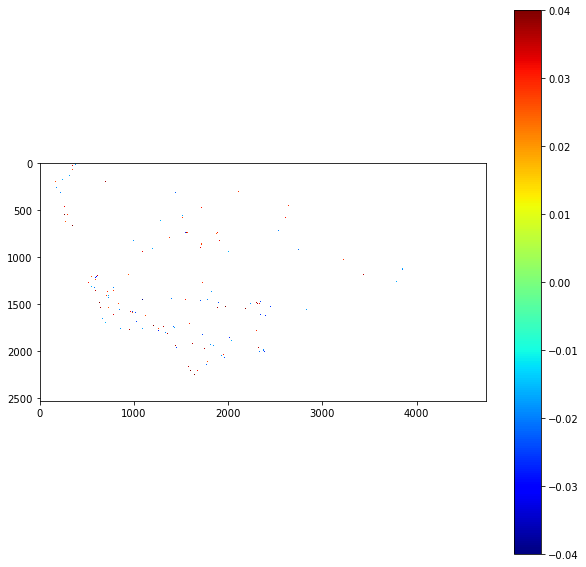

In [21]:
f = plt.figure(figsize=(10,10))
plt.imshow(up_data_both,cmap='jet',interpolation='none',vmin=-0.04,vmax=0.04)
plt.colorbar()